<center><b>DSA4212</b></center>
<center><b>Semester 2 AY21/22</b></center>
<center><b>Assignment 2</b></center>



<center>Group Number: 34  </center>
<center>Group Member 1: Shaunn Tan De Hui, A0087785H  </center>
<center>Group Member 2: Zhang Shaoxuan, A0080411X  </center>
<center>Group Member 3: Ong Jian Ying Gary, A0155664X  </center>
<center>Group Member 4: Lu Zhengjie, A0067082E  </center>

# Background

**Variance Reduction Techniques for Stochastic Gradient Descent**  

In this report, we aim to present the results of our testing of various variance reduction (VR) techniques for stochastic gradient descent (SGD) on a machine-learning problem, specifically logistic regression. Much of this first section was adapted from <a id="ref-1-back"></a>[[1]](#ref-1).

# Motivation
In machine learning, often the objective is to minimise the empirical loss with respect to a training set. The loss is typically of the form

$$ \min_{\beta\in \mathbb{R}^d}\left\{\frac{1}{n}\sum_{i}^{n}{\ell_i(\beta)+\lambda R(\beta)}\right\} = \min_{\beta\in \mathbb{R}^d}L(\beta)+\lambda R(\beta)$$

Where $\beta \in \mathbb{R}^d$ is the parameter vector of the machine-learning model, $\ell_i(\beta)$ is some loss function with respect to training data $(x_i,y_i), x_i \in \mathbb{R}^p, y_i \in \mathbb{R}, i \in \{1,...,n\}$, $\lambda$ is some regularisation constant and $R(\beta)$ is a regularisation term (e.g. L2-norm).

Traditional gradient descent would aim to minimise the loss by using the following update rule at iteration $k+1$:  
$$\begin{split}
\beta_{k+1} &= \beta_k - \eta \nabla_\beta(L(\beta_k) + \lambda R(\beta_k)) \\ 
&= \beta_k - \eta (\nabla_\beta{L(\beta_k)}+ \lambda\nabla_\beta R(\beta_k))
\end{split}$$

By the linearity of the gradient, we calculate $\nabla_\beta{\left(L(\beta)+\lambda R(\beta)\right)}$ as

$$\nabla_\beta{\left(L(\beta)+\lambda R(\beta)\right)} = \underbrace{\frac{1}{n}\sum_{i}^{n}\nabla_\beta\ell_i(\beta)}_{\text{arithmetic mean of all } \ell_i}+\lambda\nabla_\beta R(\beta)$$

Calculating the first term would take $n$ evaluations of the gradient per iteration. Since $n$ is the size of the training set, if the traning set is large, this would be computationally expensive. Hence, ways to reduce the required number of gradient evaluations were investigated, one of which was SGD, which is now very popular.

## SGD
In the basic form of SGD, we aim to approximate $\nabla_\beta{L(\beta)}$ with $\nabla_\beta{\ell_j(\beta)}$, which is the gradient of $\ell$ evaluated at one training example $(x_j,y_j)$ uniformly sampled from the training set, making the update rule:  
$$\beta_{k+1} = \beta_k - \eta \nabla_\beta(\ell_j(\beta_k) + \lambda R(\beta_k))$$

In this way, the number of gradient evaluations per iteration is reduced to $1$. SGD is known to converge to a minimum, up to some arbitrary error $\epsilon$, if the learning rate $\eta$ is properly chosen, assuming that the loss function is somewhat well-behaved (more precisely, that it is $L$-smooth and $\mu$-strictly convex). However, the rate of convergence is of order $O(1/k)$, which means that it slows down as the number of iterations $k$ increases.

This sublinear rate of convergence is because the variance of the stochastic gradient approximation does not itself converge towards zero, i.e.  
$$\mathbf{E} \left[\left\|\nabla_\beta{\ell_j(\beta_k)} - \nabla_\beta{\ell(\beta_k)}\right\|^2\right] \underset{k\rightarrow \infty}{\nrightarrow} 0$$

Methods such as an adaptive stepsize, mini-batching or momentum can be used to improve convergence, but each has their own disadvantages. Discussion of these methods is beyond the scope of this report.

## General Idea Behind Variance Reduction
Variance reduction methods aim to generate approximations $g(\beta) \approx \nabla_\beta{L(\beta)}$ that have a variance that is guaranteed to converge to zero, i.e.

$$\mathbf{E} \left[\left\|g(\beta_k) - \nabla_\beta{\ell(\beta_k)}\right\|^2\right] \underset{k\rightarrow \infty}{\rightarrow} 0$$

Such methods generally require $O(1)$ evaluations of gradients per iteration, yielding similar runtimes as SGD, but with the added property of a much faster linear rate of convergence (under the same conditions of $\ell$ being $L$-smooth and $\mu$-strongly convex) of $O\left(\mathrm{exp}(-k\rho)\right), \rho\in(0,1]$.

# Selected Variance Reduction Methods
The following section will briefly explain the variance reduction methods which we selected to test.

## Stochastic Average Gradient (SAG) 
The SAG method from <a id="ref-2-back"></a>[[2]](#ref-2)  uses the approximation $g_{sag}(\beta_k) = \displaystyle\frac{1}{n}\sum_{j=1}^{n}v_k^j$, which resembles the formula for $\nabla_\beta{L(\beta)} = \displaystyle\frac{1}{n}\sum_{i}^{n}\nabla_\beta\ell_i(\beta)$ but differs in that $v_k^j$ is updated according to the following rule every iteration:  
$$\text{Sample } i_k \text{ uniformly from } i_k \in \{1,...,n\},\; \text{then:}$$
$$v_{k+1}^j =
    \begin{cases}
    \nabla_\beta{\ell_{i_k}(\beta_k)} & \text{if } j = i_k \\
    v_k^j & \text{if } j \neq i_k
  \end{cases}$$

In other words, for iteration $k$, $v_k^j$ is an older estimate for the current value of $\nabla_\beta{\ell_{j}(\beta_k)}$, and it has a $1/n$ chance of being updated to its true current value in this iteration. Therefore, there is only $1$ gradient evaluation per iteration, like with SGD.

(The initial values $v_0^j$ can be initialised randomly (which is the approach we chose) or set to $0$.)

Since summing $n$ values of $v_k^j$ every iteration to get $g_{sag}^k$ is wasteful, a more efficient approach is to store $g_{sag}^{k}(\beta)$ and $v_k^j$ and use the update rule $g_{sag}^{k+1}(\beta) = g_{sag}^{k}(\beta) - \frac{1}{n}v_k^{i_k} + \frac{1}{n}v_{k+1}^{i_k}$

It was proved in <a id="ref-3-back"></a>[[3]](#ref-3) that the variance of $g_{sag}(\beta)$ does indeed converge to $0$ as $k \rightarrow \infty$, meaning that it is a VR method with a linear rate of convergence. 

## Stochastic Variance Reduced Gradient (SVRG) 
A disadvantage of SAG is that $g_{sag}(\beta)$ is that it requires storing $v_k^j, j \in \{1,...n\}$, which may be a substantial amount of memory if $n$ is large. In order to reduce this requirement, SVRG from <a id="ref-4-back"></a>[[4]](#ref-4) introduces the concept of a *reference point* $\bar{\beta}$ where the full gradient $\nabla_\beta L(\bar{\beta})$ (i.e. a single real vector in $\mathbb{R}^d$) is calculated, and then uses the following approximation for $\nabla_\beta{L(\beta)} \approx g_{svrg}(\beta)$:  
$$\text{Sample } i_k \text{ uniformly from } i_k \in \{1,...,n\},\; \text{then:}$$
$$\begin{split}
g_{svrg}^{k+1}(\beta_k) &= \nabla_\beta{\ell_{i_k}(\beta_k)} - \nabla_\beta{\ell_{i_k}(\bar{\beta})} + \nabla_\beta L(\bar{\beta}) \\
&= \nabla_\beta{\ell_{i_k}(\beta_k)} - \nabla_\beta{\ell_{i_k}(\bar{\beta})} + \underbrace{\frac{1}{n}\sum_{j=1}^{n}\nabla_\beta{\ell_{j}(\bar{\beta})}}_{\text{this is pre-computed and stored}}
\end{split}$$  
Note that $\displaystyle\frac{1}{n}\sum_{j=1}^{n}\nabla_\beta{\ell_{j}(\bar{\beta})} = \mathbf{E}[\nabla_\beta{\ell_{i_k}(\bar{\beta})}]$ since $i_k$ is uniformly sampled.

The reference point $\bar{\beta}$ can be initialized in several ways, but a commonly-used one (and the approach that we use) is to run naive SGD over several iterations, starting from a random initialization, and use that result as the reference point.

At first glance, it does not seem to make much sense why introducing the reference point would be useful at all, but it actually serves to reduce the variance of $g_{svrg}(\beta)$ through a statistical method known as "control variates".

(The following is adapted from <a id="ref-5-back"></a>[[5]](#ref-5))

Assume we have two random variables $x$ and $z$ and define a third one $x_z = x - z + \mathbf{E}[z]$:
$$\begin{split}
\mathbf{E}\left[(x_z-\mathbf{E}[x_z])^2\right] &= \mathbf{E}\left[\left((x-z+\mathbf{E}[z])-\mathbf{E}[x-z+\mathbf{E}[z]]\right)^2\right] \\
&= \mathbf{E}[((x-z+\mathbf{E}[z])-(\mathbf{E}[x]-\mathbf{E}[z]+\underbrace{\mathbf{E}[\mathbf{E}[z]]}_{=\mathbf{E}[z]}))^2] \\
&= \mathbf{E}[(x-z+\mathbf{E}[z]-(\mathbf{E}[x]\underbrace{-\mathbf{E}[z]+\mathbf{E}[z]}_{=0}))^2] \\
&= \mathbf{E}[((x-\mathbf{E}[x])-(z-\mathbf{E}[z]))^2] \\
&= \mathbf{E}[(x-\mathbf{E}[x])^2-2(x-\mathbf{E}[x])(z-\mathbf{E}[z])+(z-\mathbf{E}[z])^2] \\
&= \mathbf{Var}[x]-2\mathbf{Cov}[x,z]+\mathbf{Var}[z]
\end{split}$$

If $\mathbf{Cov}\left[x,z\right] \gt 0$, the variance of their sum can be potentially be lower than their individual variances.

Comparing terms with the SVRG update rule, we can see that $x = \nabla_\beta{\ell_{i_k}(\beta_k)}$, $z = \nabla_\beta{\ell_{i_k}(\bar{\beta})}$ and $\mathbf{E}[z]=\nabla_\beta L(\bar{\beta})$. If $\beta_k \approx \bar{\beta}$, $\mathbf{Cov}\left[\beta_k,\bar{\beta}\right]$ is higher and hence the variance of $g_{svrg}(\beta)$ decreases.

However, since in general $\bar{\beta}$ is not the location of the minima, and every update of $g_{svrg}(\beta_k)$ moves $\beta_k$ closer (in general) to said minimum, there is the need to update the location of $\bar{\beta}$ and to evaluate the full gradient at that new reference point. To avoid excessively updating the reference point, it is updated only every stage of $s$ iterations, where $s$ is a parameter that has to be tuned.

Since the variance of $g_{svrg}(\beta_k)$ converges to $0$ as the number of iterations increase, SVRG is a VR method and has a linear rate of convergence as well.

SVRG's update rule saves on memory compared to SAG because it removes the need of storing $n$ values of individual gradients, but trades this memory advantage for more computation as, compared to SAG, this update rule requires the evaluation of $2$ gradients $\nabla_\beta{\ell_{i_k}(\beta_k)}$ and $\nabla_\beta{\ell_{i_k}(\bar{\beta})}$ per iteration, as well as calculating a full gradient every stage of $s$ iterations.

## Stochastic Average Gradient "amélioré" (SAGA) 
SAGA <a id="ref-6-back"></a> [[6]](#ref-6) was introduced as a "middle-point" between SAG and SVRG, combining concepts from both. Compared to SAG, it uses an unbiased approximation of $\nabla_\beta L(\beta)$ and is easier to analyse its statistical properties, hence the "amélioré" (improved) attached to its name.

Like SVRG, SAGA uses the control variate method to reduce variance, but instead of using a single fixed reference point $\bar{\beta}$ and its sampled and full gradients $\nabla_\beta\ell_{i_k}(\bar{\beta})$ and $\nabla_\beta{L(\bar{\beta})}$, it replaces $\nabla_\beta{L(\bar{\beta})}$ with an estimate $\bar{g} = \displaystyle\frac{1}{n}\sum_{j=1}^{n}v_k^j$ (similar to SAG), and $\nabla_\beta\ell_{i_k}(\bar{\beta})$ with a uniformly sampled gradient from a previous iteration $\nabla_\beta\ell_{i_k}(\beta_k)$. The update rule is as follows:

$\text{Sample } i_k \text{ uniformly from } i_k \in \{1,...,n\},\; \text{then:}$  
1. $v^{old} = v^{i_k}_k$  
2. $v_{k+1}^j =
    \begin{cases}
    \nabla_\beta{\ell_{i_k}(\beta_k)} & \text{if } j = i_k \\
    v_k^j & \text{if } j \neq i_k
  \end{cases}$  
3. $g_{saga}^{k+1}(\beta_k) = v_{k+1}^j - v^{old} + \bar{g}_k$  
4. $\bar{g}_{k+1} = \displaystyle\frac{1}{n}\sum_{j=1}^{n}v_{k+1}^j$

Once again, it can be seen that $v_{old}$ and $\bar{g}$ are equivalent to $z$ and $\mathbf{E}[z]$ in the control variate method, and that $v_{old}$ and $v_{k+1}^j$ are correlated random variables, leading again to a variance that converges to $0$ and a linear rate of convergence.

SAGA, like SAG, requires $1$ gradient evaluation per iteration and the memory to store the $n$ values of $v_j^k$. The calculation of $\bar{g}$ can be made more efficient in a similar manner to that for $g_{sag}(\beta)$.

### SAG, SAGA and SVRG as variations of a generalized control variates technique

(The following was adapted from <a id="ref-6-back-2"></a> [[6]](#ref-6))  

A small observation is that both SAGA and SAG can be derived from a modification of the control variates method, whereby an additional multiplier term $\alpha$ is inserted into $x_z$ to give $x_{z,\alpha} = \alpha(x - z) + \mathbf{E}[z]$. Then,  
$$\mathbf{E}[x_{z,\alpha}] = \alpha\mathbf{E}[x] + (1-\alpha)\mathbf{E}[z]$$
$$\mathbf{Var}[x_{z,\alpha}] = \alpha^2(\mathbf{Var}[x] + \mathbf{Var}[z] - 2\mathbf{Cov}[x,z])$$

Compared to the conventional control variates method, it can be seen that $\alpha$ allows one to trade off bias and variance. As $\alpha$ is varied from 0 towards 1, the variance of $x_{z,\alpha}$ is increased towards the maximum value (which, if $\mathbf{Cov}[x,z] \gt 0$, may still be less than $\mathbf{Var}[x]$), while its bias (i.e. $\mathbf{E}[x_{z,\alpha}] - \mathbf{E}[x]$) is decreased to 0.  

We set  $x$ as the sampled gradient for the current iteration $\nabla_{\beta}\ell_{i_k}(\beta_k)$ and $z$ as a gradient calculated at some previous location $\beta^{old}_k$, in other words $\nabla_{\beta}\ell_{i_k}(\beta^{old}_k)$.  

We observe that the gradient descent updates in the variance reduction algorithms discussed above can be summarized as follows:  

**SAG**: $\beta_{k+1} = \beta_k - \eta\left[\displaystyle\frac{\nabla_{\beta}\ell_{i_k}(\beta_k) - \nabla_{\beta}\ell_{i_k}(\beta^{old}_k)}{n} + \displaystyle\frac{1}{n}\sum_{j=1}^{n}\nabla_{\beta}\ell_{j}(\beta^{old}_k)\right]$  

**SAGA**: $\beta_{k+1} = \beta_k - \eta\left[\displaystyle{\nabla_{\beta}\ell_{i_k}(\beta_k) - \nabla_{\beta}\ell_{i_k}(\beta^{old}_k)} + \displaystyle\frac{1}{n}\sum_{j=1}^{n}\nabla_{\beta}\ell_{j}(\beta^{old}_k)\right]$  

**SVRG**: $\beta_{k+1} = \beta_k - \eta\left[\displaystyle{\nabla_{\beta}\ell_{i_k}(\beta_k) - \nabla_{\beta}\ell_{i_k}(\bar{\beta})} + \frac{1}{n}\sum_{j=1}^{n}\nabla_\beta{\ell_{j}(\bar{\beta})}\right]$  


From the above, we can see that SAG is actually obtained using $\alpha = \frac{1}{n}$ (making $g_{sag}(\beta)$ a biased estimator), whereas SAGA is obtained using $\alpha = 1$ (making $g_{saga}(\beta)$ an ubiased estimator) and using the same past gradients saved. We can also see that the variance of the SAG update is $\frac{1}{n^2}$ times that of SAGA.  

The SVRG update is obtained using average of past gradients with $\alpha = 1$(thus making it also an unbiased estimator).  

SAGA can be viewed as a midpoint between SVRG and SAG, as it updates its "reference point" $\beta^{old}_{k}$ each time an index $i_k$ is picked, whereas SVRG updates the reference point $\bar{\beta}$ every stage of $s$ iterations.  

In [1]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy
import jax
import jax.numpy as jnp
import dill as pickle

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Dataset

To compare the performance of the various variance reduction algorithms, we peformed experiments on the 'Personal Key Indicators of Heart Disease' dataset from Kaggle ([link](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease)).  

The dataset came from the US CDC as part of the Behavioral Risk Factor Surveillance System. The original dataset contains some 300 variables, which was reduced to 18 relevant variables related to individual characteristics (e.g. BMI, Age Category, etc) and lifestyle characteristics (e.g. Smoking, Alcohol Drinking, etc.).  

The full dataset contains 319,795 records, of which approximately 8.56% of the records belong to individuals with heart disease. We utilise the dataset to perform a **classification** task, predicting if an individual has heart disease based on 17 other variables, using logistic regression.

As we are primarily concerned about the performance of the variance reduction algorithms, we focused on creating a balanced dataset to facilitate our experiments by performing the following pre-processing procedure:  

1. Create dummy variables for the categorical variables and add an intercept term.  
2. Under-sample the pool of records belonging to individuals with no heart disease to the same count as the number of records with heart disease.  
3. Randomly select 2,000 records from the pool of records with and without heart disease to form the test set.  
4. From the remaining records, randomly select 10,000 records to from the training set.  

The training set therefore has approximately 50% of records belonging to individuals with heart disease.

In [ ]:
# !kaggle datasets download -d kamilpytlak/personal-key-indicators-of-heart-disease
# !tar -xf personal-key-indicators-of-heart-disease.zip

In [ ]:
data = pd.read_csv('heart_2020_cleaned.csv')
categoricals = ['HeartDisease','Smoking','AlcoholDrinking','Stroke','DiffWalking','Sex',
                'AgeCategory','Race','Diabetic','PhysicalActivity','GenHealth','Asthma',
                'KidneyDisease','SkinCancer']
for cat in categoricals:
    print(f'{cat}: {sorted(data[cat].unique())}')

HeartDisease: ['No', 'Yes']
Smoking: ['No', 'Yes']
AlcoholDrinking: ['No', 'Yes']
Stroke: ['No', 'Yes']
DiffWalking: ['No', 'Yes']
Sex: ['Female', 'Male']
AgeCategory: ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']
Race: ['American Indian/Alaskan Native', 'Asian', 'Black', 'Hispanic', 'Other', 'White']
Diabetic: ['No', 'No, borderline diabetes', 'Yes', 'Yes (during pregnancy)']
PhysicalActivity: ['No', 'Yes']
GenHealth: ['Excellent', 'Fair', 'Good', 'Poor', 'Very good']
Asthma: ['No', 'Yes']
KidneyDisease: ['No', 'Yes']
SkinCancer: ['No', 'Yes']


In [ ]:
data_dummies = pd.get_dummies(data, columns = categoricals, drop_first = True)
print(f'Number of records: {len(data_dummies)}')
print(f'% of observations with Heart Disease: {round(data_dummies["HeartDisease_Yes"].mean()*100,2)}%')
data_dummies['HeartDisease_Yes'] = np.where(data_dummies['HeartDisease_Yes'] == 1, 1, -1)
data_dummies['intercept'] = 1

Number of records: 319795
% of observations with Heart Disease: 8.56%


Dataset is imbalanced. As the dataset is large, we will under-sample the observations with HeartDisease == 'No' to create a balanced dataset for our experiments.

In [ ]:
# split up the dataset in to 2, with and without heart disease, to under-sample the observations with heart disease
hd_no = data_dummies[data_dummies['HeartDisease_Yes']==-1].copy()
hd_yes = data_dummies[data_dummies['HeartDisease_Yes']==1].copy()

# create random indices and under-sample the observations without heart disease
random_select = np.random.choice(len(hd_no), size=len(hd_yes), replace = False)
hd_no_2 = hd_no.iloc[random_select].copy()

# create random index to perform train-test split
random_select_hdno_test = np.random.choice(len(hd_no_2), size=2000, replace = False)
random_select_hdno_train = np.setdiff1d(np.arange(len(hd_no_2)),random_select_hdno_test)
random_select_hdyes_test = np.random.choice(len(hd_yes), size=2000, replace = False)
random_select_hdyes_train = np.setdiff1d(np.arange(len(hd_yes)),random_select_hdyes_test)

# create training and testing datasets
x_train = np.vstack((hd_no_2.iloc[random_select_hdno_train,].drop(columns = 'HeartDisease_Yes').to_numpy(),
                    hd_yes.iloc[random_select_hdyes_train,].drop(columns = 'HeartDisease_Yes').to_numpy()))
x_test = np.vstack((hd_no_2.iloc[random_select_hdno_test,].drop(columns = 'HeartDisease_Yes').to_numpy(),
                    hd_yes.iloc[random_select_hdyes_test,].drop(columns = 'HeartDisease_Yes').to_numpy()))
y_train = np.vstack((hd_no_2.iloc[random_select_hdno_train,][['HeartDisease_Yes']].to_numpy(),
                    hd_yes.iloc[random_select_hdyes_train,][['HeartDisease_Yes']].to_numpy())).squeeze()
y_test = np.vstack((hd_no_2.iloc[random_select_hdno_test,][['HeartDisease_Yes']].to_numpy(),
                    hd_yes.iloc[random_select_hdyes_test,][['HeartDisease_Yes']].to_numpy())).squeeze()

# shuffle the train set
indices = np.random.choice(len(x_train), size=10000, replace = False)
np.random.shuffle(indices)

# select 10,000 random for training
x_train = x_train[indices]
y_train = y_train[indices]

Next, we use JAX to setup the required functions to perform SGD for a logistic regression.

In [ ]:
# setup logistic regression
@jax.jit
def singleLoss(b, x, y):
    return jnp.log(1 + jnp.exp(-y * jnp.dot(b, x)))

@jax.jit
def meanLoss(b, x, y):
    vmapLoss = jax.vmap(singleLoss, in_axes = (None, 0, 0))
    lossArray = vmapLoss(b, x, y)
    return jnp.mean(lossArray)

@jax.jit
def allLoss(b, x, y):
    vmapLoss = jax.vmap(singleLoss, in_axes = (None, 0, 0))
    lossArray = vmapLoss(b, x, y)
    return lossArray

singlelossGrad = jax.jit(jax.value_and_grad(singleLoss, argnums = 0))
lossGrad = jax.jit(jax.value_and_grad(meanLoss, argnums = 0))
alllossGrad = jax.jit(jax.value_and_grad(allLoss, argnums = 0))

@jax.jit
def predictOne(b, x):
    return 1 / (1 + jnp.exp(-1 * jnp.dot(b,x)))

@jax.jit
def predictAll(b, x):
    vmapPred = jax.vmap(predictOne, in_axes = (None, 0))
    preds = vmapPred(b, x)
    return jnp.where(preds > 0.5, 1, -1)

@jax.jit
def predictAllLogits(b, x):
    vmapPred = jax.vmap(predictOne, in_axes = (None, 0))
    preds = vmapPred(b, x)
    return preds

def getTrainTestAcc(b, traindata, testdata, attrtrain, attrtest):
    epochpreds_test = predictAll(b, testdata)
    epochpreds_test = np.array(epochpreds_test)
    test_accuracy_iter = np.mean(epochpreds_test == attrtest)
    
    epochpreds_train = predictAll(b, traindata)
    epochpreds_train = np.array(epochpreds_train)
    train_accuracy_iter = np.mean(epochpreds_train == attrtrain)
    return train_accuracy_iter, test_accuracy_iter

# Comparing the Perfomance of VR Algorithms

We compare the performance of 4 gradient descent algorithms, comparing the rate at which test accuracy increases based on the number of effective dataset passes:
$$ \text{Effective dataset passes} = \frac{\text{No. of gradient computations}}{\text{Number of training dataset observations}}$$  

For each algorithm, we attempt to achieve approximately 50 effective training dataset passes worth of gradient computations, under a single sample per iteration setup with the following parameters:  

1. **Naive SGD**: Learning Rate = 0.0001  
2. **SAG**: Learning Rate = 0.0001  
3. **SVRG**: Stages = 17, Iterations per Stage: 20,000, Learning Rate = 0.0001 (authors suggested using 2n iterations per stage)  
4. **SAGA**: Learning Rate = 0.0001  


## Naive SGD

In [ ]:
def trainsgd(traindata, attrtrain, testdata, attrtest, lr, iters = 100, **kwargs):
    # tracking
    lossHistory = []
    test_acc = []
    train_acc = []
    lr_history = []
    iteration_history = []
    
    # get data dimensions
    trainsize = traindata.shape[0]
    testsize = testdata.shape[0]
    dim = traindata.shape[1]

    # intialize for SAG
    b = np.random.normal(0, 1/np.sqrt(dim), size = dim)
    b_tracking = np.zeros((trainsize,dim))
    d = np.zeros(dim)
    
    t = 0
   
    for i in tqdm(range(iters)):
        # randomly select an index
        idx = np.random.randint(0, high = trainsize)
        
        x_train_sel = traindata[idx]
        y_train_sel = attrtrain[idx]
        
        v, g = singlelossGrad(b, x_train_sel, y_train_sel)
        
        b = b - lr * g
        
        # get metrics
        # if (i+1) % 50 == 0:    
        loss = meanLoss(b, traindata, attrtrain)
        lossHistory.append(loss)      
        train_accuracy_iter, test_accuracy_iter = getTrainTestAcc(b, traindata, testdata, attrtrain, attrtest)
        train_acc.append(train_accuracy_iter)        
        test_acc.append(test_accuracy_iter)
        iteration_history.append(i+1)
    
    return train_acc, test_acc, lossHistory, iteration_history, b

In [ ]:
trainacc_sgd, testacc_sgd, lossHistory_sgd, iteration_history_sgd, b_sgd = \
trainsgd(x_train, y_train, x_test, y_test, lr = 0.0001, iters = 500000)

In [ ]:
# with open('sgd.pkl', 'wb') as file:
#     pickle.dump((trainacc_sgd, testacc_sgd, lossHistory_sgd, iteration_history_sgd, b_sgd), file)

## Stochastic Average Gradient

In [ ]:
def trainsag(traindata, attrtrain, testdata, attrtest, lr, iters = 100, **kwargs):
    # tracking
    lossHistory = []
    test_acc = []
    train_acc = []
    lr_history = []
    iteration_history = []
    
    # get data dimensions
    trainsize = traindata.shape[0]
    testsize = testdata.shape[0]
    dim = traindata.shape[1]

    # intialize for SAG
    b = np.random.normal(0, 1/np.sqrt(dim), size = dim)
    b_tracking = np.zeros((trainsize,dim))
    d = np.zeros(dim)
    
    t = 0
   
    for i in tqdm(range(iters)):
        # randomly select an index
        idx = np.random.randint(low = 0, high = trainsize)

        x_train_sel = traindata[idx]
        y_train_sel = attrtrain[idx]
        
        v, g = singlelossGrad(b, x_train_sel, y_train_sel)
        
        d = d - (1/trainsize) * b_tracking[idx] + (1/trainsize) * g
        
        b_tracking[idx] = g
        
        b = b - lr * d
        
        # get metrics
        # if (i+1) % 50 == 0:   
        loss = meanLoss(b, traindata, attrtrain)
        lossHistory.append(loss)      
        train_accuracy_iter, test_accuracy_iter = getTrainTestAcc(b, traindata, testdata, attrtrain, attrtest)
        train_acc.append(train_accuracy_iter)        
        test_acc.append(test_accuracy_iter)
        iteration_history.append(i+1)
    
    return train_acc, test_acc, lossHistory, iteration_history, b

In [ ]:
trainacc_sag, testacc_sag, lossHistory_sag, iteration_history_sag, b_sag = \
trainsag(x_train, y_train, x_test, y_test, lr = 0.0001, iters = 500000)

In [ ]:
# with open('sag.pkl', 'wb') as file:
#     pickle.dump((trainacc_sag, testacc_sag, lossHistory_sag, iteration_history_sag, b_sag), file)

## SVRG

In [ ]:
def trainsvrg(traindata, attrtrain, testdata, attrtest, stages, lr, m = 100, initialize = 100, **kwargs):
    # tracking
    lossHistory = []
    test_acc = []
    train_acc = []
    lr_history = []
    iteration_history = []
    
    # get data dimensions
    trainsize = traindata.shape[0]
    testsize = testdata.shape[0]
    dim = traindata.shape[1]

    # intialize for SVRG
    b = np.random.normal(0, 1/np.sqrt(dim), size = dim)
    b_tracking = np.zeros((trainsize,dim))
    b_average = np.zeros(dim)
    
    t = 0
    
    for j in range(initialize):
        idx = np.random.randint(0, high = trainsize)

        x_train_sel = traindata[idx]
        y_train_sel = attrtrain[idx]

        v, g = singlelossGrad(b, x_train_sel, y_train_sel)
        
        b = b - lr * g

    i = 0
    for s in tqdm(range(stages)):
        
        b_stagestart = b.copy()
        mu = np.zeros(dim)
        
        for obs in range(trainsize):

            x_train_sel = traindata[obs]
            y_train_sel = attrtrain[obs]
            
            v, g = singlelossGrad(b, x_train_sel, y_train_sel)
            mu = mu + g
            
            i += 1
            
        mu = mu/trainsize
        
        for m in range(m):
            # randomly select an index
            idx = np.random.randint(0, high = trainsize)

            x_train_sel = traindata[idx]
            y_train_sel = attrtrain[idx]

            v_m, g_m = singlelossGrad(b, x_train_sel, y_train_sel)
            v_ss, g_ss = singlelossGrad(b_stagestart, x_train_sel, y_train_sel)

            b = b - lr * (g_m - g_ss + mu)
             
            # get metrics
            # if (i+1) % 50 == 0:    
            loss = meanLoss(b, traindata, attrtrain)
            lossHistory.append(loss)      
            train_accuracy_iter, test_accuracy_iter = getTrainTestAcc(b, traindata, testdata, attrtrain, attrtest)
            train_acc.append(train_accuracy_iter)        
            test_acc.append(test_accuracy_iter)
            iteration_history.append(i+1)
        
            i += 1
    
    return train_acc, test_acc, lossHistory, iteration_history, b

In [ ]:
trainacc_svrg, testacc_svrg, lossHistory_svrg, iteration_history_svrg, b_svrg = \
trainsvrg(x_train, y_train, x_test, y_test, stages = 17, lr = 0.0001, m = 20000)

In [ ]:
# with open('svrg.pkl', 'wb') as file:
#     pickle.dump((trainacc_svrg, testacc_svrg, lossHistory_svrg, iteration_history_svrg, b_svrg), file)

## SAGA

In [ ]:
def trainsaga(traindata, attrtrain, testdata, attrtest, lr, iters = 100, **kwargs):
    # tracking
    lossHistory = []
    test_acc = []
    train_acc = []
    lr_history = []
    iteration_history = []
    
    # get data dimensions
    trainsize = traindata.shape[0]
    testsize = testdata.shape[0]
    dim = traindata.shape[1]

    # intialize for SAGA
    b = np.random.normal(0, 1/np.sqrt(dim), size = dim)
    b_tracking = np.zeros((trainsize,dim))
    b_average = np.zeros(dim)
    
    t = 0
   
    for i in tqdm(range(iters)):
        # randomly select an index
        idx = np.random.randint(0, high = trainsize)
        
        x_train_sel = traindata[idx]
        y_train_sel = attrtrain[idx]
        
        v, g = singlelossGrad(b, x_train_sel, y_train_sel)
        
        b = b - lr * (g - b_tracking[idx] + b_average)
        
        # update table average
        b_average = ((b_average * trainsize) -  b_tracking[idx] + g)/trainsize
        
        # update table
        b_tracking[idx] = g
              
        # get metrics
        # if (i+1) % 50 == 0:    
        loss = meanLoss(b, traindata, attrtrain)
        lossHistory.append(loss)      
        train_accuracy_iter, test_accuracy_iter = getTrainTestAcc(b, traindata, testdata, attrtrain, attrtest)
        train_acc.append(train_accuracy_iter)        
        test_acc.append(test_accuracy_iter)
        iteration_history.append(i+1)
        
    return train_acc, test_acc, lossHistory, iteration_history, b

In [ ]:
trainacc_saga, testacc_saga, lossHistory_saga, iteration_history_saga, b_saga = \
trainsaga(x_train, y_train, x_test, y_test, lr = 0.0001, iters = 500000)

In [ ]:
# with open('saga.pkl', 'wb') as file:
#     pickle.dump((trainacc_saga, testacc_saga, lossHistory_saga, iteration_history_saga, b_saga), file)

# Plot

The test accuracy and loss are plotted in Figures 1 and 2 respectively.

In [2]:
# load saved experiment data
# with open('sgd.pkl', 'rb') as file:
#     trainacc_sgd, testacc_sgd, lossHistory_sgd, iteration_history_sgd, b_sgd = pickle.load(file)

# with open('sag.pkl', 'rb') as file:
#     trainacc_sag, testacc_sag, lossHistory_sag, iteration_history_sag, b_sag = pickle.load(file)

# with open('svrg.pkl', 'rb') as file:
#     trainacc_svrg, testacc_svrg, lossHistory_svrg, iteration_history_svrg, b_svrg = pickle.load(file)

# with open('saga.pkl', 'rb') as file:
#     trainacc_saga, testacc_saga, lossHistory_saga, iteration_history_saga, b_saga = pickle.load(file)

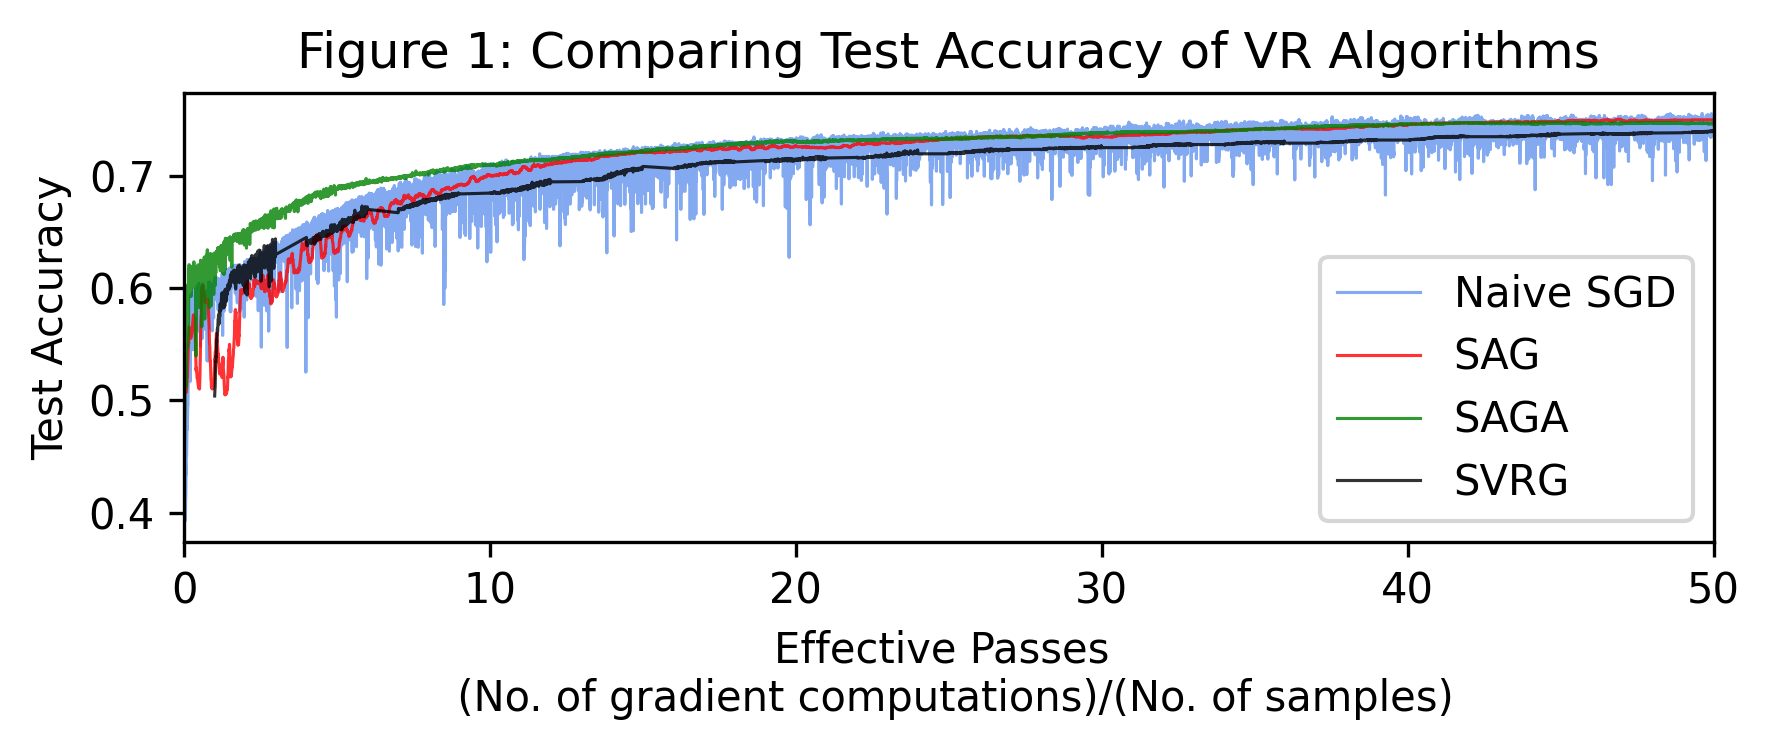

In [8]:
plt.figure(figsize=(6,2.6))
plt.plot(np.array(iteration_history_sgd[::50])/10000,testacc_sgd[::50], alpha = 0.8, color = 'cornflowerblue', lw = 0.75, label = 'Naive SGD')
plt.plot(np.array(iteration_history_sag[::50])/10000,testacc_sag[::50], alpha = 0.8, color = 'red', lw = 0.75, label = 'SAG')
plt.plot(np.array(iteration_history_saga[::50])/10000,testacc_saga[::50], alpha = 0.8, color = 'green', lw = 0.75, label = 'SAGA')
plt.plot(np.array(iteration_history_svrg[::50])/10000,testacc_svrg[::50], alpha = 0.8, color = 'black', lw = 0.75, label = 'SVRG')
plt.legend()
plt.xlim((0,50))
plt.title('Figure 1: Comparing Test Accuracy of VR Algorithms')
plt.ylabel('Test Accuracy')
plt.xlabel('Effective Passes \n (No. of gradient computations)/(No. of samples)')
plt.gcf().set_dpi(300)
plt.tight_layout()
plt.show()

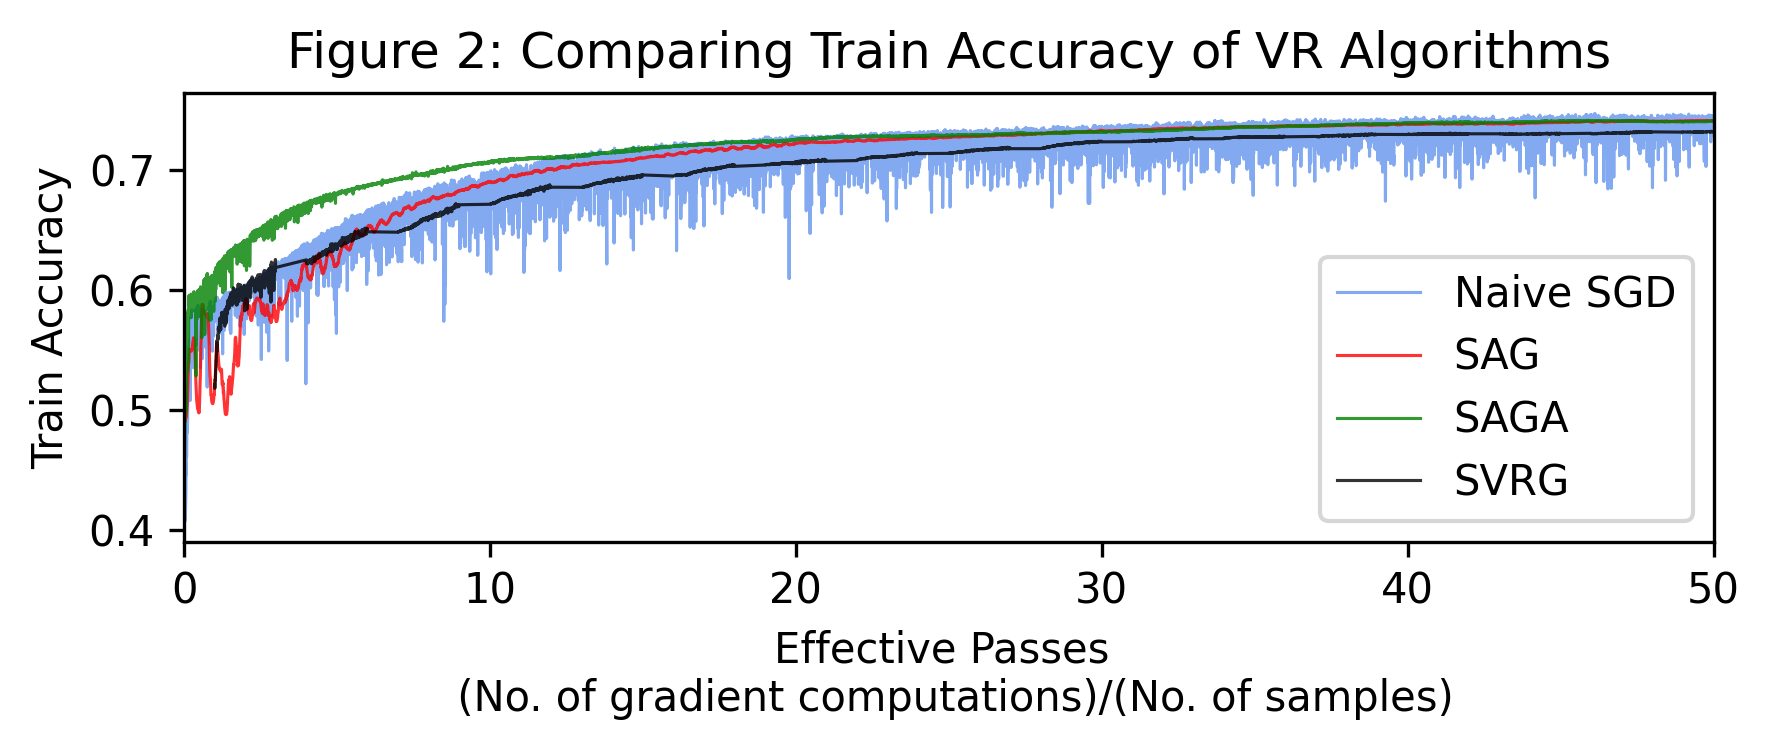

In [13]:
plt.figure(figsize=(6,2.6))
plt.plot(np.array(iteration_history_sgd[::50])/10000,trainacc_sgd[::50], alpha = 0.8, color = 'cornflowerblue', lw = 0.75, label = 'Naive SGD')
plt.plot(np.array(iteration_history_sag[::50])/10000,trainacc_sag[::50], alpha = 0.8, color = 'red', lw = 0.75, label = 'SAG')
plt.plot(np.array(iteration_history_saga[::50])/10000,trainacc_saga[::50], alpha = 0.8, color = 'green', lw = 0.75, label = 'SAGA')
plt.plot(np.array(iteration_history_svrg[::50])/10000,trainacc_svrg[::50], alpha = 0.8, color = 'black', lw = 0.75, label = 'SVRG')
plt.legend()
plt.xlim((0,50))
plt.title('Figure 2: Comparing Train Accuracy of VR Algorithms')
plt.ylabel('Train Accuracy')
plt.xlabel('Effective Passes \n (No. of gradient computations)/(No. of samples)')
plt.gcf().set_dpi(300)
plt.tight_layout()
plt.show()

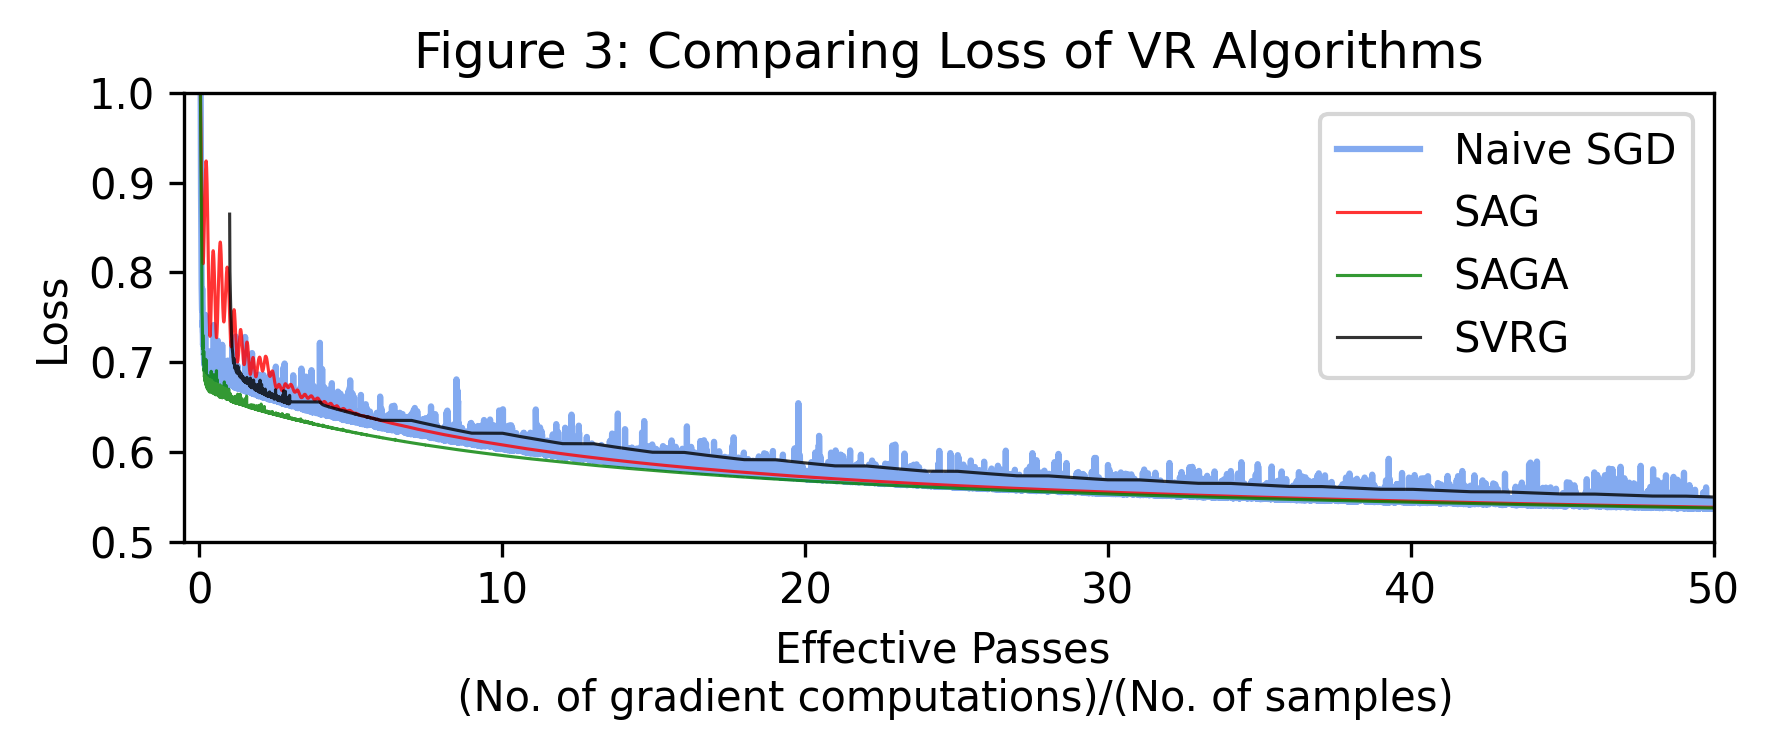

In [7]:
plt.figure(figsize=(6,2.6))
plt.plot(np.array(iteration_history_sgd[::50])/10000,lossHistory_sgd[::50], alpha = 0.8, color = 'cornflowerblue', label = 'Naive SGD')
plt.plot(np.array(iteration_history_sag[::50])/10000,lossHistory_sag[::50], alpha = 0.8, color = 'red', lw = 0.75, label = 'SAG')
plt.plot(np.array(iteration_history_saga[::50])/10000,lossHistory_saga[::50], alpha = 0.8, color = 'green', lw = 0.75, label = 'SAGA')
plt.plot(np.array(iteration_history_svrg[::50])/10000,lossHistory_svrg[::50], alpha = 0.8, color = 'black', lw = 0.75, label = 'SVRG')
plt.legend()
plt.xlim((-0.5,50))
# plt.yscale('log')
plt.title('Figure 3: Comparing Loss of VR Algorithms')
plt.ylim(top=1, bottom=0.5)
plt.ylabel('Loss')
plt.xlabel('Effective Passes \n (No. of gradient computations)/(No. of samples)')
plt.gcf().set_dpi(300)
plt.tight_layout()
plt.show()

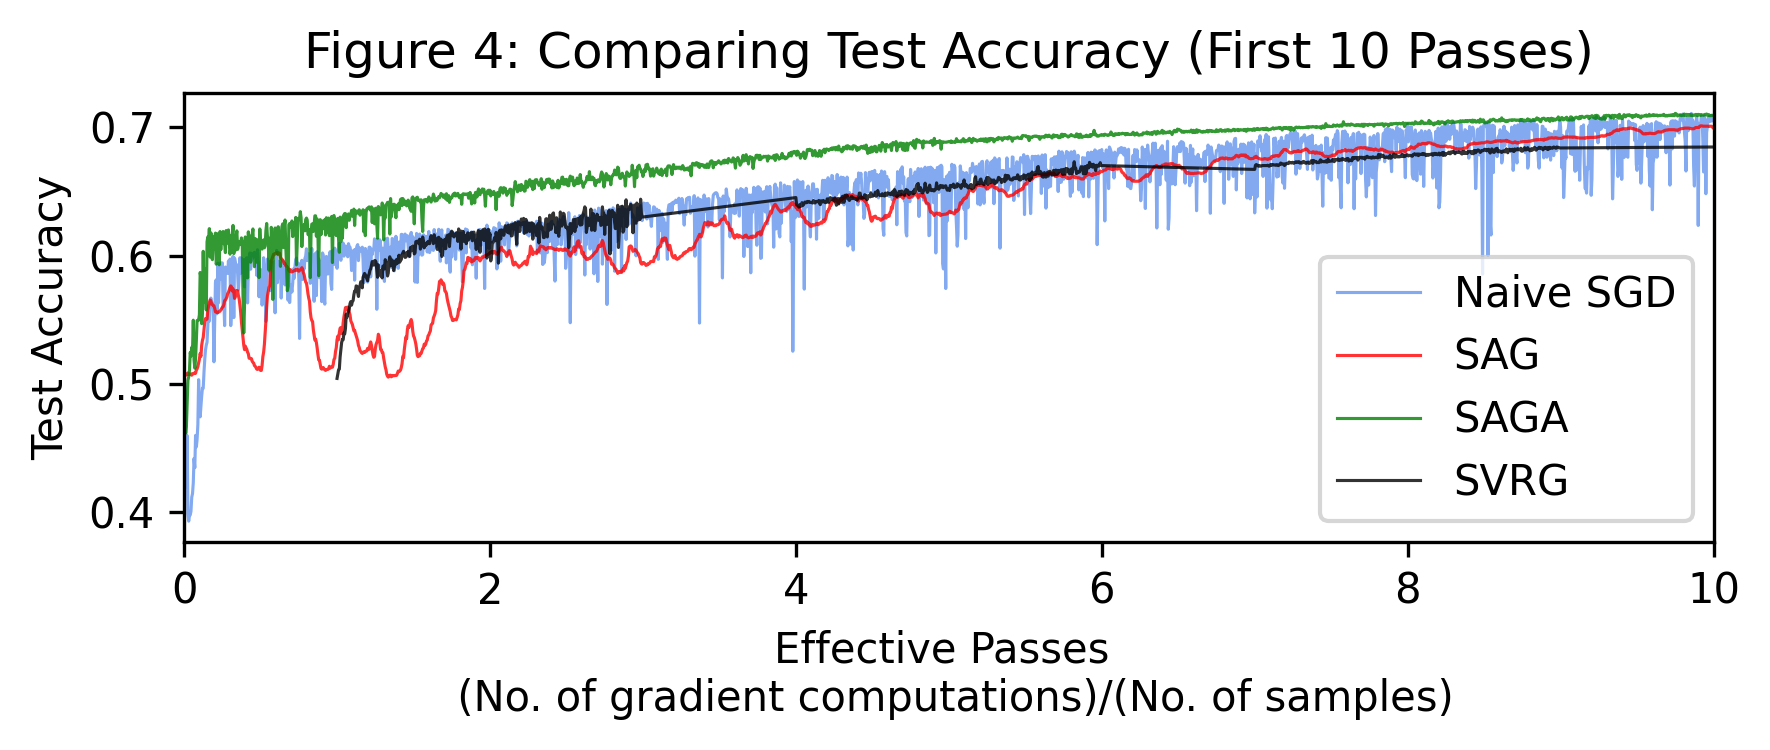

In [11]:
plt.figure(figsize=(6,2.6))
plt.plot(np.array(iteration_history_sgd[:100000:50])/10000,testacc_sgd[:100000:50], alpha = 0.8, color = 'cornflowerblue', lw = 0.75, label = 'Naive SGD')
plt.plot(np.array(iteration_history_sag[:100000:50])/10000,testacc_sag[:100000:50], alpha = 0.8, color = 'red', lw = 0.75, label = 'SAG')
plt.plot(np.array(iteration_history_saga[:100000:50])/10000,testacc_saga[:100000:50], alpha = 0.8, color = 'green', lw = 0.75, label = 'SAGA')
plt.plot(np.array(iteration_history_svrg[:100000:50])/10000,testacc_svrg[:100000:50], alpha = 0.8, color = 'black', lw = 0.75, label = 'SVRG')
plt.legend()
plt.xlim((0,10))
plt.title('Figure 4: Comparing Test Accuracy (First 10 Passes)')
plt.ylabel('Test Accuracy')
plt.xlabel('Effective Passes \n (No. of gradient computations)/(No. of samples)')
plt.gcf().set_dpi(300)
plt.tight_layout()
plt.show()

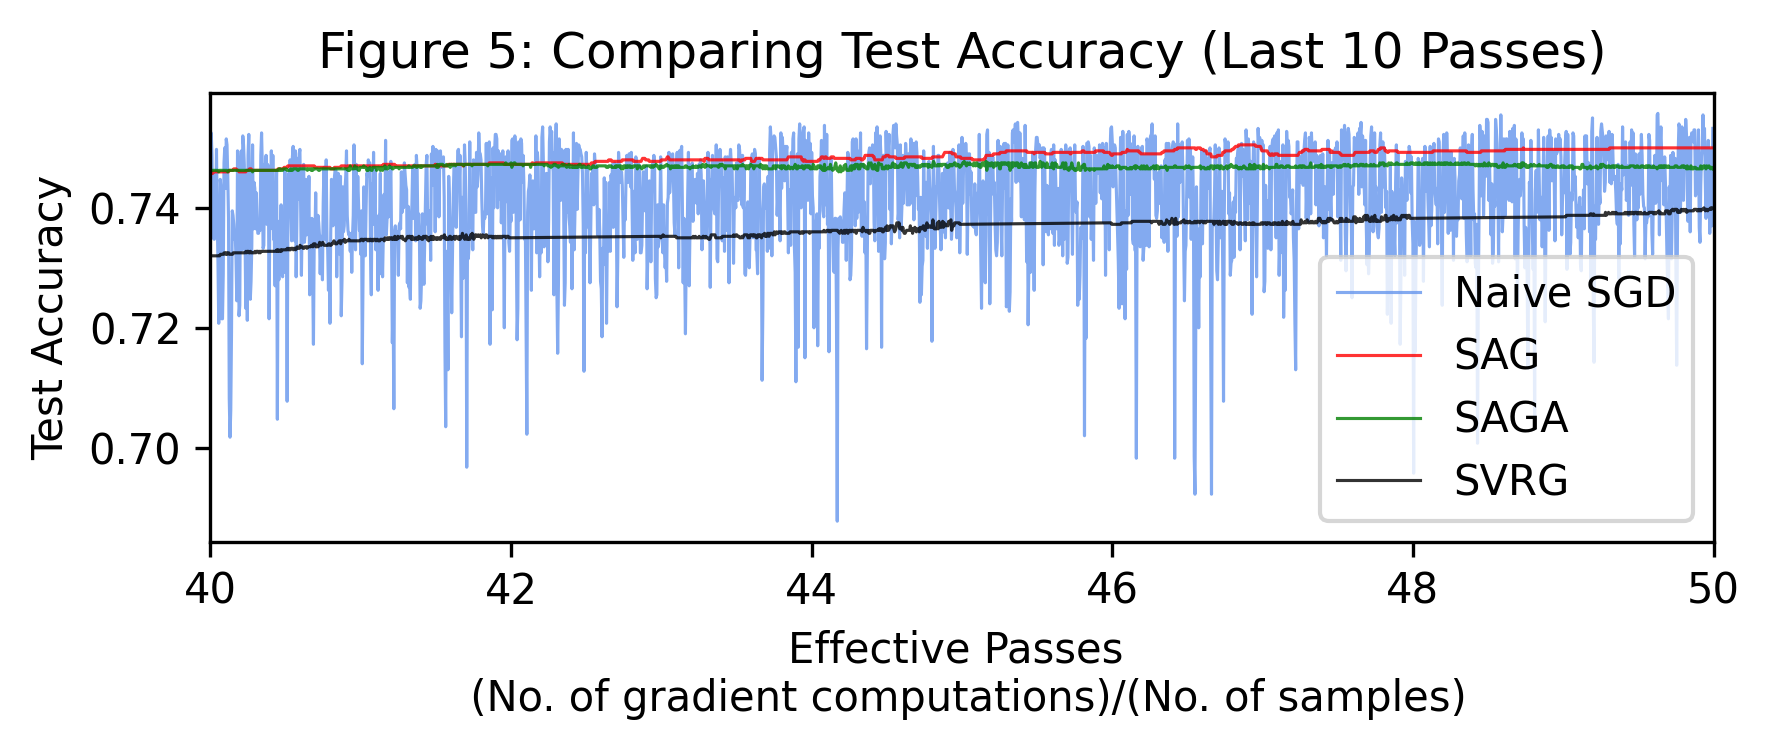

In [12]:
plt.figure(figsize=(6,2.6))
plt.plot(np.array(iteration_history_sgd[-100000::50])/10000,testacc_sgd[-100000::50], alpha = 0.8, color = 'cornflowerblue', lw = 0.75, label = 'Naive SGD')
plt.plot(np.array(iteration_history_sag[-100000::50])/10000,testacc_sag[-100000::50], alpha = 0.8, color = 'red', lw = 0.75, label = 'SAG')
plt.plot(np.array(iteration_history_saga[-100000::50])/10000,testacc_saga[-100000::50], alpha = 0.8, color = 'green', lw = 0.75, label = 'SAGA')
plt.plot(np.array(iteration_history_svrg[-100000::50])/10000,testacc_svrg[-100000::50], alpha = 0.8, color = 'black', lw = 0.75, label = 'SVRG')
plt.legend()
plt.xlim((40,50))
plt.title('Figure 5: Comparing Test Accuracy (Last 10 Passes)')
plt.ylabel('Test Accuracy')
plt.xlabel('Effective Passes \n (No. of gradient computations)/(No. of samples)')
plt.gcf().set_dpi(300)
plt.tight_layout()
plt.show()

Visually, noting the numerous spikes and dips in both train and test accuracy and loss, it is easy to conclude that the Naive SGD algorithm has high variation in its updates. The opposite was noted for SAG, SVRG, and SAGA. These VR algorithms clearly achieves the variance reduction intent.

However, while the 3 mentioned VR algorithms appear to perform similarly with sufficient number of effective dataset passes, we noted the following key observations:  

1. SAGA performed the best even when there are few effective passes through the data. (see figures 1 to 4)
2. SAG performs pooly with too few effective passes through the data, poor accuracy and large fluctuations in loss and test accuracy were noted. Test accuracy can be worse than naive SGD (see figure 4). Furthermore, if $n$ is large, it may be computationally infeasible to utilise SAG with sufficient number of effective data set passes to achieve VR.
3. SAG and SAGA have the same per iteration cost of $O(1)$ and per effective pass cost of $O(n)$. Given so, SAGA is preferable over SAG for the higher accuracy with fewer dataset passes.
4. SVRG requires a full gradient computation at the beginning of each stage with a cost of $O(n)$ and for each stage $m$ iterations are performed for a total per stage cost of $O(m + n)$. Authors suggested using $m = 2n$. SVRG may be infeasible if $n$ is large.
5. SAG eventually overtakes SAGA in test accuracy. We hypothesise that this is might be dataset dependent.

Considering the above-mentioned points, there is a clear advantage in using SAGA, over SAG and SVRG.

# Summary

In this report, we compared the effect of variance reduction of 3 VR algorithms relative to the Naive SGD algorithm. We noted the clear VR effect of the 3 algorithms and noted that, on the whole, SAGA performed the best on the 'Personal Key Indicators of Heart Disease' dataset from Kaggle. SAG and SVRG may have disadvantages when the training dataset is large.

To further ascertain the benefits of SAGA, similar experiments should be carried out on different datasets.

# References
<a id="ref-1"></a> [[1]](#ref-1-back) R. M. Gower, M. Schmidt, F. Bach and P. Richtárik, "Variance-Reduced Methods for Machine Learning," in *Proceedings of the IEEE*, vol. 108, no. 11, pp. 1968-1983, Nov. 2020, doi: 10.1109/JPROC.2020.3028013.

<a id="ref-2"></a> [[2]](#ref-2-back) R. N. Roux, M. Schmidt and F. Bach, "A stochastic gradient method with an exponential convergence rate for finite training sets", *Proc. Adv. Neural Inf. Process. Syst.*, pp. 2663-2671, 2012.

<a id="ref-3"></a> [[3]](#ref-3-back) M. Schmidt, N. Le Roux and F. Bach, "Minimizing finite sums with the stochastic average gradient", *Math. Program.*, vol. 162, no. 1, pp. 83-112, 2017.

<a id="ref-4"></a> [[4]](#ref-4-back) Johnson, R. and Zhang, T. (2013). Accelerating stochastic gradient descent using predictive variance reduction. In *Advances in Neural Information Processing Systems 26*, pages 315–323.

<a id="ref-5"></a> [[5]](#ref-5-back) Francis Bach and Robert M. Gower, "Optimization for Machine Learning Stochastic Variance Reduced Gradient Methods," 2019. [Online] Available: https://gowerrobert.github.io/pdf/AMMI/optimization_IV_variance_reduced-expanded.pdf [Accessed Apr. 9, 2022].

<a id="ref-6"></a> [[6]](#ref-6-back) A. Defazio, F. Bach and S. Lacoste-Julien, "SAGA: A fast incremental gradient method with support for non-strongly convex composite objectives", *Proc. Adv. Neural Inf. Process. Syst.*, pp. 1646-1654, 2014.